In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:0

In [ ]:
!nvidia-smi

Tue Apr 25 07:56:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model_ckpt = "microsoft/prophetnet-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_prophetnet = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.9/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
dataset_meqsum = load_dataset("bigbio/meqsum")

split_lengths = [len(dataset_meqsum[split])for split in dataset_meqsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_meqsum['train'].column_names}")
print("\nDialogue:")

print(dataset_meqsum["train"][1]["CHQ"])

print("\nSummary:")

print(dataset_meqsum["train"][1]["Summary"])

Generating train split: 0 examples [00:00, ? examples/s]

Dataset meqsum downloaded and prepared to /root/.cache/huggingface/datasets/bigbio___meqsum/meqsum_source/1.0.0/c4bedfa7ded6ccdacecffeff1d64d6592fa27518c6b8d04d0217f3e77b4c092a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Split lengths: [1000]
Features: ['File', 'CHQ', 'Summary']

Dialogue:
who makes bromocriptine
i am wondering what company makes the drug bromocriptine, i need it for a mass i have on my pituitary gland and the cost just keeps raising. i cannot ever buy a full prescription because of the price and i was told if i get a hold of the maker of the drug sometimes they offer coupons or something to help me afford the medicine. if i buy 10 pills in which i have to take 2 times a day it costs me 78.00. and that is how i have to buy them.  thanks.

Summary:
Who manufactures bromocriptine?


In [ ]:
# Evaluating the ProphetNet on MeqSUM data
dataset_meqsum['train'][0]['CHQ']

'SUBJECT: who and where to get cetirizine - D\nMESSAGE: I need/want to know who manufscturs Cetirizine. My Walmart is looking for a new supply and are not getting the recent'

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_meqsum['train'][0]['CHQ'] )

print(pipe_out)

/usr/local/lib/python3.9/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Your max_length is set to 142, but you input_length is only 48. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


[{'summary_text': 'are the'}]


In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_meqsum['train'], rouge_metric,
                                    model_prophetnet, tokenizer, column_text = 'CHQ',
                                    column_summary='Summary', batch_size=8)

<ipython-input-11-fb2d48fa7bfc>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')



100%|██████████| 125/125 [33:35<00:00, 16.13s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['prophetnet'])

,rouge1,rouge2,rougeL,rougeLsum
prophetnet,0.01402,0.00004,0.013716,0.013711


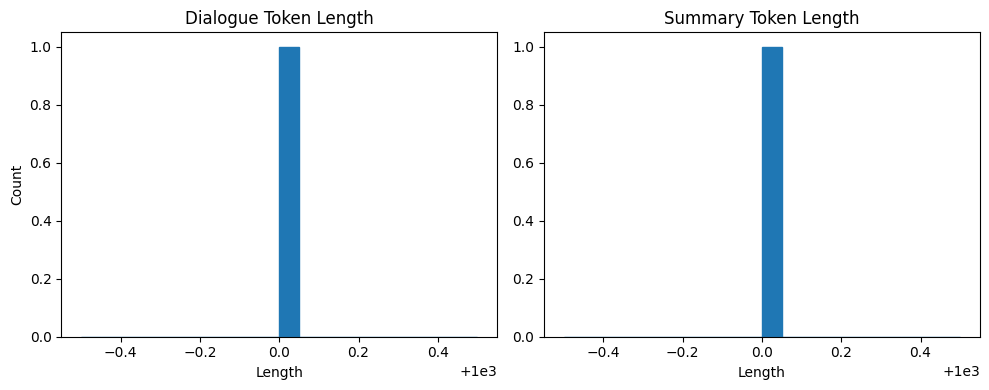

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_meqsum['train']['CHQ']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_meqsum['train']['Summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['CHQ'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['Summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_meqsum_pt = dataset_meqsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
dataset_meqsum_pt['train'][0]

{'File': '1-131188152.xml.txt',
 'CHQ': 'SUBJECT: who and where to get cetirizine - D\nMESSAGE: I need/want to know who manufscturs Cetirizine. My Walmart is looking for a new supply and are not getting the recent',
 'Summary': 'Who manufactures cetirizine?',
 'input_ids': [3395,
  1024,
  2040,
  1998,
  2073,
  2000,
  2131,
  8292,
  3775,
  21885,
  3170,
  1011,
  1040,
  4471,
  1024,
  1045,
  2342,
  1013,
  2215,
  2000,
  2113,
  2040,
  2158,
  16093,
  11020,
  20689,
  2015,
  8292,
  3775,
  21885,
  3170,
  1012,
  2026,
  24547,
  22345,
  2003,
  2559,
  2005,
  1037,
  2047,
  4425,
  1998,
  2024,
  2025,
  2893,
  1996,
  3522,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [2040, 22027, 8292, 3775, 21885, 3170, 1029, 102]}

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_prophetnet)

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='prophetnet-meqsum', num_train_epochs=18, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [ ]:
dataset_meqsum_pt

DatasetDict({
    train: Dataset({
        features: ['File', 'CHQ', 'Summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
trainer = Trainer(model=model_prophetnet, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_meqsum_pt["train"],
                  eval_dataset=dataset_meqsum_pt["train"])

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
500,0.532500,0.223087
1000,0.021200,0.001931


TrainOutput(global_step=1116, training_loss=0.8067454687289654, metrics={'train_runtime': 3740.6903, 'train_samples_per_second': 4.812, 'train_steps_per_second': 0.298, 'total_flos': 3146504878153728.0, 'train_loss': 0.8067454687289654, 'epoch': 17.86})

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['prophetnet'])

,rouge1,rouge2,rougeL,rougeLsum
prophetnet,0.01402,0.00004,0.013716,0.013711


In [ ]:
## Save model
model_prophetnet.save_pretrained("prophetnet-meqsum-model")

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/prophetnet.tokenizer',
 'tokenizer/added_tokens.json')

In [ ]:
dataset_meqsum = load_dataset("bigbio/meqsum")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
sample_text = dataset_meqsum["train"][0]["CHQ"]

reference = dataset_meqsum["train"][0]["Summary"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="prophetnet-meqsum-model",tokenizer=tokenizer)

In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 48. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Dialogue:
SUBJECT: who and where to get cetirizine - D
MESSAGE: I need/want to know who manufscturs Cetirizine. My Walmart is looking for a new supply and are not getting the recent

Reference Summary:
Who manufactures cetirizine?

Model Summary:
who manufactures cetirizine , and who manufactures it ?


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive

 1.png
'210880721-JATIN SALVE-Guided Tour (2) (1).pdf'
'2. JAF 2022 (1) (1).gdoc'
'2. JAF 2022 (1).gdoc'
'6. Undertaking-May 2019 (1).docx'
'Action Plan .gdoc'
'Astable multivibrator.pptx'
'Astra Task JS.zip'
'BPCL CERTIFICATE.pdf'
'B.TECH ELECTRONICS List of Students .xlsx'
 CAP1_CUTOFF_DSE.gdoc
 CERTIFICATES.pdf
 Classroom
'Coding .gdoc'
'Colab Notebooks'
'Copy of Bianca · SlidesCarnival.gslides'
'Copy of Bitcoin Company Pitch Deck by Slidesgo.gslides'
'Copy of Data Science Consulting by Slidesgo.gslides'
'Copy of Greg Mat Vocab List (32 Groups, 960 Words).gsheet'
'Copy of JS_RESUME_GOOGLE.pdf'
'Copy of NLP_LAB2.gdoc'
'Copy of Rmae.gslides'
'Copy of Road Construction Thesis Defense by Slidesgo.gslides'
'Copy of Simple Animated Birthday by Slidesgo.gslides'
'Copy of Web Project Proposal by Slidesgo.gslides'
'Course Completion Certificate (1).jpg'
'Course Completion Certificate.jpg'
'Coursera Python.pdf'
'Cover Letter.gdoc'
'Docker Notebook.gdoc'
"Electronics - Details if you haven't r

In [ ]:
## Save model
model_prophetnet.save_pretrained("prophetnet-meqsum-model")

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/prophetnet.tokenizer',
 'tokenizer/added_tokens.json')

In [ ]:
pwd

'/content'

In [ ]:
ls

ls: cannot access 'drive': Transport endpoint is not connected
drive/   prophetnet-meqsum/        sample_data/
gdrive/  prophetnet-meqsum-model/  tokenizer/


In [ ]:
cd gdrive

/content/gdrive


In [ ]:
ls

MyDrive/


In [ ]:
cd MyDrive

/content/gdrive/MyDrive


In [ ]:
ls

 1.png
'210880721-JATIN SALVE-Guided Tour (2) (1).pdf'
'2. JAF 2022 (1) (1).gdoc'
'2. JAF 2022 (1).gdoc'
'6. Undertaking-May 2019 (1).docx'
'Action Plan .gdoc'
'Astable multivibrator.pptx'
'Astra Task JS.zip'
'BPCL CERTIFICATE.pdf'
'B.TECH ELECTRONICS List of Students .xlsx'
 CAP1_CUTOFF_DSE.gdoc
 CERTIFICATES.pdf
 Classroom/
'Coding .gdoc'
'Colab Notebooks'/
'Copy of Bianca · SlidesCarnival.gslides'
'Copy of Bitcoin Company Pitch Deck by Slidesgo.gslides'
'Copy of Data Science Consulting by Slidesgo.gslides'
'Copy of Greg Mat Vocab List (32 Groups, 960 Words).gsheet'
'Copy of JS_RESUME_GOOGLE.pdf'
'Copy of NLP_LAB2.gdoc'
'Copy of Rmae.gslides'
'Copy of Road Construction Thesis Defense by Slidesgo.gslides'
'Copy of Simple Animated Birthday by Slidesgo.gslides'
'Copy of Web Project Proposal by Slidesgo.gslides'
'Course Completion Certificate (1).jpg'
'Course Completion Certificate.jpg'
'Coursera Python.pdf'
'Cover Letter.gdoc'
'Docker Notebook.gdoc'
"Electronics - Details if you haven't

In [ ]:
cd saved_model

/content/gdrive/MyDrive/saved_model


In [ ]:
pwd

'/content/gdrive/MyDrive/saved_model'

In [ ]:
## Save model
model_prophetnet.save_pretrained("prophetnet-meqsum-model")

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/prophetnet.tokenizer',
 'tokenizer/added_tokens.json')